![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 09. <i>Metody głębokiego uczenia (1)</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższym materiale zobaczymy w jaki sposób korzystać z metod głębokiego uczenia sieci neuronowych w pakiecie OpenCV.

Na początku załadujmy niezbędne biblioteki:

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

OpenCV wspiera [wiele](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) bibliotek i modeli sieci neuronowych. Modele trenuje się poza OpenCV - bibliotekę wykorzystuje się tylko do predykcji, aczkolwiek sama w sobie ma całkiem sporo możliwych optymalizacji w porównaniu do źródłowych bibliotek neuronowych, więc predykcja może być tutaj faktycznie szybsza.

Pliki z modelami i danymi pomocniczymi będziemy pobierali z sieci i będziemy je zapisywali w katalogu `dnn`:

In [2]:
!mkdir -p dnn

# Klasyfikacja obrazów

Spróbujemy wykorzystać sieć do klasyfikacji obrazów wyuczonej na zbiorze [ImageNet](https://www.image-net.org/). Pobierzmy plik zawierający opis 1000 możliwych klas:

In [5]:
!curl -o dnn/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/opencv/opencv/master/samples/data/dnn/classification_classes_ILSVRC2012.txt 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 21675  100 21675    0     0  63979      0 --:--:-- --:--:-- --:--:-- 64317


Spójrzmy na pierwsze pięć klas w pliku:

In [6]:
with open('dnn/classification_classes_ILSVRC2012.txt', 'r') as f_fd:
    classes = f_fd.read().splitlines()
    
print(len(classes), classes[:5])

1000 ['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


Do klasyfikacji użyjemy sieci [DenseNet](https://arxiv.org/abs/1608.06993). Pobierzemy jedną z mniejszych [reimplementacji](https://github.com/shicai/DenseNet-Caffe), która jest hostowana m.in. na Google Drive (musimy doinstalować jeden pakiet):

In [7]:
!pip3 install --user --disable-pip-version-check gdown

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [8]:
import gdown

url = 'https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE'
output = 'dnn/DenseNet_121.caffemodel'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE
To: c:\Develop\wmi\AITECH\sem2\wko\aitech-wko-pub\dnn\DenseNet_121.caffemodel
100%|██████████| 32.3M/32.3M [00:01<00:00, 18.9MB/s]


'dnn/DenseNet_121.caffemodel'

In [11]:
!curl -o dnn/DenseNet_121.prototxt https://raw.githubusercontent.com/shicai/DenseNet-Caffe/master/DenseNet_121.prototxt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  7 76474    7  5484    0     0  16613      0  0:00:04 --:--:--  0:00:04 16668
100 76474  100 76474    0     0   201k      0 --:--:-- --:--:-- --:--:--  201k


Konkretne biblioteki neuronowe posiadają dedykowane funkcje do ładowania modeli, np. [`readNetFromCaffe()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29d0ea5e52b1d1a6c2681e3f7d68473a) lub [`readNetFromTorch()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga65a1da76cb7d6852bdf7abbd96f19084), jednak można też użyć ogólnej [`readNet()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422):

In [12]:
model = cv.dnn.readNet(model='dnn/DenseNet_121.prototxt', config='dnn/DenseNet_121.caffemodel', framework='Caffe')

Spróbujemy sklasyfikować poniższy obraz:

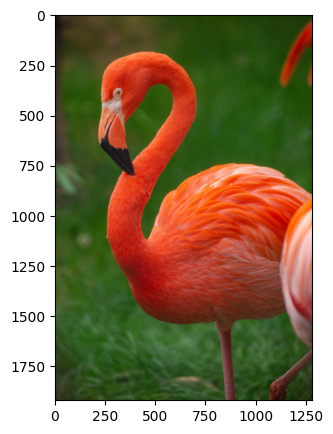

In [13]:
image = cv.imread('img/flamingo.jpg')
plt.figure(figsize=[5,5])
plt.imshow(image[:,:,::-1]);

Aby móc przepuścić obraz przez sieć musimy zmienić jego formę reprezentacji poprzez funkcję [`blobFromImage()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7). Aby uzyskać sensowne dane musimy ustawić parametry dotyczące preprocessingu (informacje o tym są zawarte na [stronie modelu](https://github.com/shicai/DenseNet-Caffe)):

In [14]:
image_blob = cv.dnn.blobFromImage(image=image, scalefactor=0.017, size=(224, 224), mean=(104, 117, 123), 
                                  swapRB=False, crop=False)

Ustawiamy dane wejściowe w naszej sieci i pobieramy obliczone wartości:

In [15]:
model.setInput(image_blob)
outputs = model.forward()[0]

Wyliczamy która klasa jest najbardziej prawdopodobna:

In [16]:
outputs = outputs.reshape(1000, 1)

label_id = np.argmax(outputs)

probs = np.exp(outputs) / np.sum(np.exp(outputs))

Wynik:

99.99 %


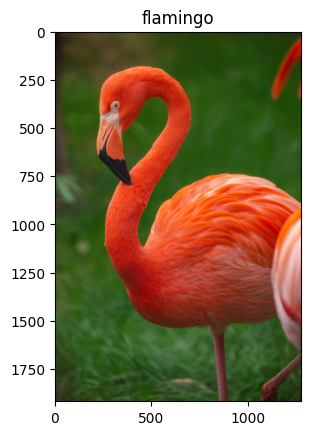

In [17]:
plt.imshow(image[:,:,::-1])
plt.title(classes[label_id])
print("{:.2f} %".format(np.max(probs) * 100.0))

# Wykrywanie twarzy

Do wykrywania twarzy użyjemy sieci bazującej na [SSD](https://github.com/weiliu89/caffe/tree/ssd):

In [20]:
!curl -o dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
!curl -o dnn/res10_300x300_ssd_iter_140000_fp16.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5225k    0  5484    0     0   7979      0  0:11:10 --:--:--  0:11:10  7982
100 5225k  100 5225k    0     0  4114k      0  0:00:01  0:00:01 --:--:-- 4117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4 28104    4  1371    0     0   4689      0  0:00:05 --:--:--  0:00:05  4695
100 28104  100 28104    0     0  93388      0 --:--:-- --:--:-- --:--:-- 93368


Ładujemy model:

In [21]:
model = cv.dnn.readNet(model='dnn/res10_300x300_ssd_iter_140000_fp16.prototxt', config='dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel', framework='Caffe')

Będziemy chcieli wykryć twarze na poniższym obrazie:

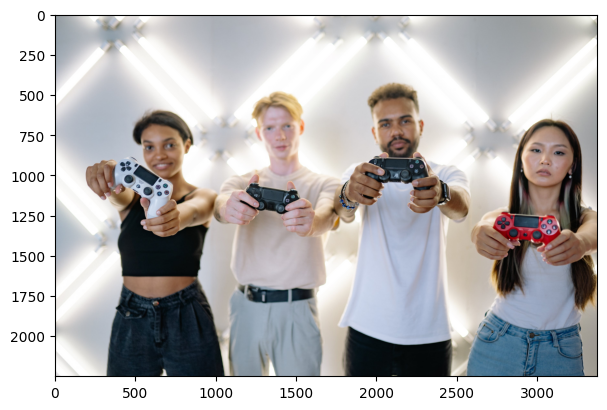

In [22]:
image = cv.imread('img/people.jpg')
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Znajdujemy twarze i oznaczamy je na zdjęciu (za próg przyjęliśmy 0.5; zob. informacje o [preprocessingu](https://github.com/opencv/opencv/tree/master/samples/dnn#face-detection)):

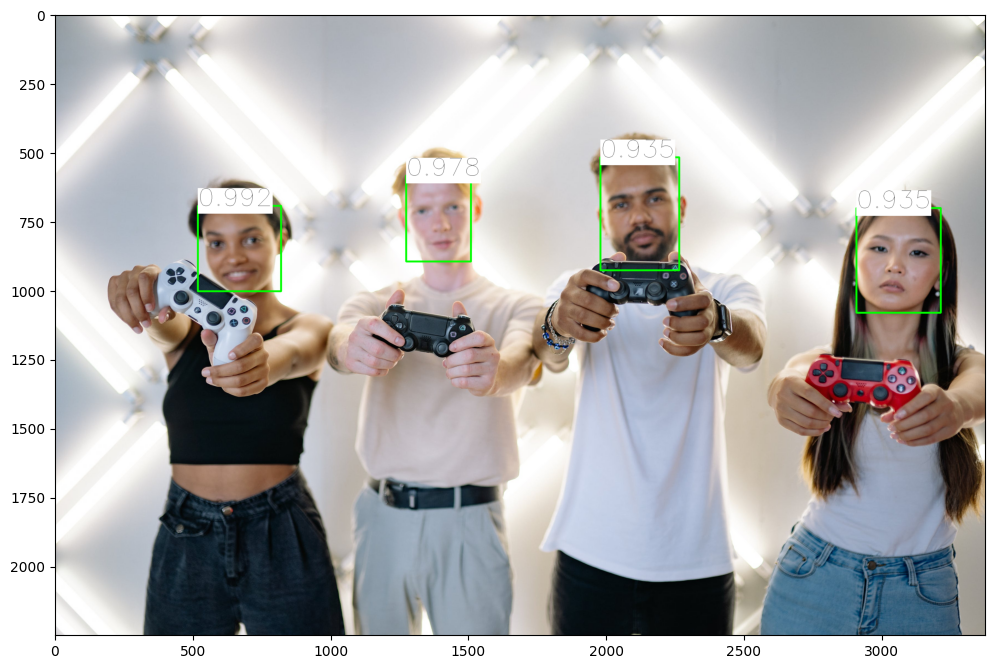

In [26]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=[104, 177, 123], 
                                  swapRB=False, crop=False)

model.setInput(image_blob)

detections = model.forward()

image_out = image.copy()

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:

        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (x1, y1, x2, y2) = box.astype('int')

        cv.rectangle(image_out, (x1, y1), (x2, y2), (0, 255, 0), 6)
        label = '{:.3f}'.format(confidence)
        label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 3.0, 1)
        cv.rectangle(image_out, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                      (255, 255, 255), cv.FILLED)
        cv.putText(image_out, label, (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 3.0, (0, 0, 0))
        
plt.figure(figsize=[12,12])
plt.imshow(image_out[:,:,::-1]);

## Punkty charakterystyczne twarzy

W OpenCV jest możliwość wykrywania punktów charakterystycznych twarzy (ang. *facial landmarks*). Użyjemy zaimplementowanego [modelu](http://www.jiansun.org/papers/CVPR14_FaceAlignment.pdf) podczas Google Summer of Code przy użyciu [`createFacemarkLBF()`](https://docs.opencv.org/4.5.3/d4/d48/namespacecv_1_1face.html#a0bec73a729ed878430c2feb9ce65bc2a):

In [29]:
!curl -o dnn/lbfmodel.yaml https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 53.7M    0  2742    0     0   1342      0 11:40:08  0:00:02 11:40:06  1343
  9 53.7M    9 5302k    0     0  2069k      0  0:00:26  0:00:02  0:00:24 2069k
 44 53.7M   44 24.1M    0     0  6946k      0  0:00:07  0:00:03  0:00:04 6945k
 79 53.7M   79 42.6M    0     0  9558k      0  0:00:05  0:00:04  0:00:01 9557k
100 53.7M  100 53.7M    0     0  10.4M      0  0:00:05  0:00:05 --:--:-- 13.6M


In [30]:
landmark_detector = cv.face.createFacemarkLBF()
landmark_detector.loadModel('dnn/lbfmodel.yaml')

Ograniczamy nasze poszukiwania do twarzy:

In [31]:
faces = []

for detection in detections[0][0]:
    if detection[2] >= 0.5:
        left   = detection[3] * width
        top    = detection[4] * height
        right  = detection[5] * width
        bottom = detection[6] * height

        face_w = right - left
        face_h = bottom - top

        face_roi = (left, top, face_w, face_h)
        faces.append(face_roi)

faces = np.array(faces).astype(int)

_, landmarks_list = landmark_detector.fit(image, faces)

Model generuje 68 punktów charakterycznych, które możemy zwizualizować:

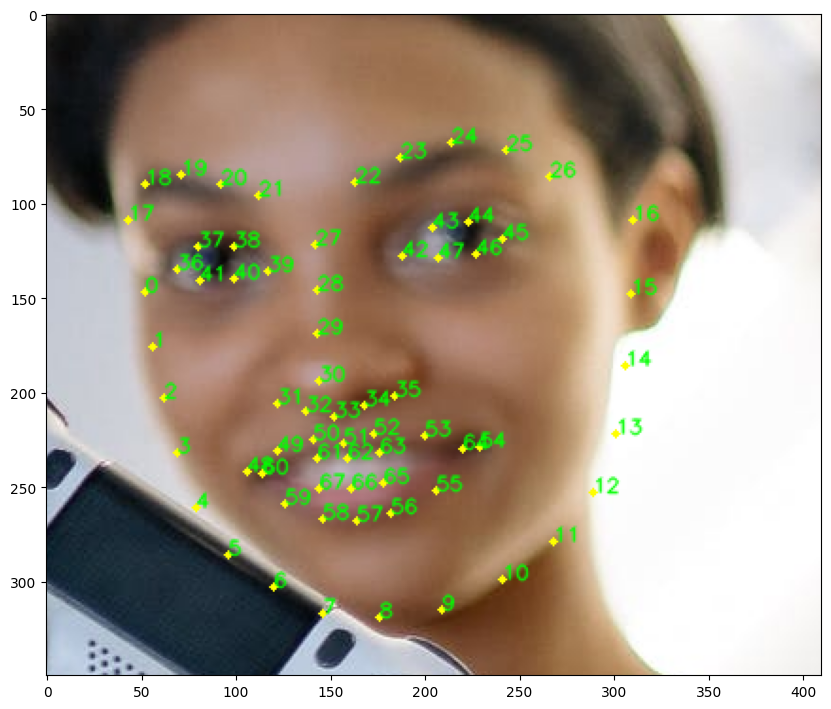

In [32]:
image_display = image.copy()
landmarks = landmarks_list[0][0].astype(int)

for idx, landmark in enumerate(landmarks):
    cv.circle(image_display, landmark, 2, (0,255,255), -1)
    cv.putText(image_display, str(idx), landmark, cv.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1, 
                cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(image_display[700:1050,500:910,::-1]);

Jeśli nie potrzebujemy numeracji, to możemy użyć prostszego podejścia, tj. funkcji [`drawFacemarks()`](https://docs.opencv.org/4.5.3/db/d7c/group__face.html#ga318d9669d5ed4dfc6ab9fae2715310f5):

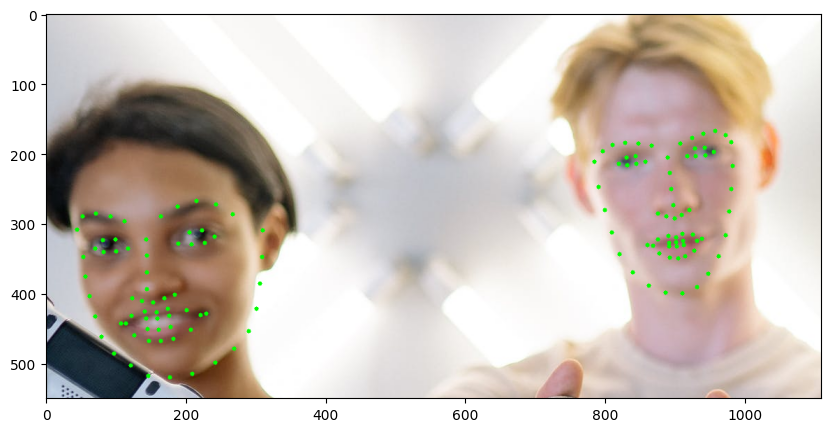

In [33]:
image_display = image.copy()
for landmarks_set in landmarks_list:
    cv.face.drawFacemarks(image_display, landmarks_set, (0, 255, 0))

plt.figure(figsize=(10,10))
plt.imshow(image_display[500:1050,500:1610,::-1]);

# Zadanie 1

W katalogu `vid` znajdują się filmy `blinking-*.mp4`. Napisz program do wykrywania mrugnięć. Opcjonalnie możesz użyć *eye aspect ratio* z [tego artykułu](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf) lub zaproponować własne rozwiązanie.

In [36]:
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2

ModuleNotFoundError: No module named 'dlib'

In [2]:
!python3 blink_detection_lab8.py -v vid/blinking-man.mp4 -p shape_predictor_68_face_landmarks.dat   

Traceback (most recent call last):
  File "blink_detection_lab8.py", line 10, in <module>
    import dlib
ModuleNotFoundError: No module named 'dlib'


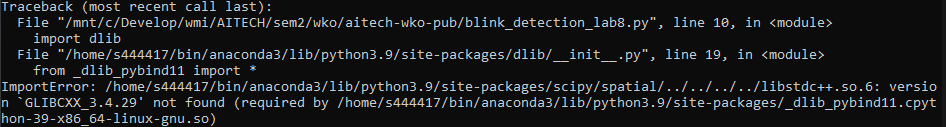